# Imports required

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

# !pip install deap

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import operator
import random

import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.4 MB/s eta 0:00:00


Loading in CIFAR-10

In [2]:
# The dataset comes in data of the range 0-1, we want to convert this to -1 to 1 as part of normalisation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Function to transform the dataset to the specified range

batch_size = 512

# Downloading the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Loading the training set into a variable
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# etc.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Specifying the classes of the dataset that we want to train the classifier on
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 42309439.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Testing for GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Testing to see if we can see the images

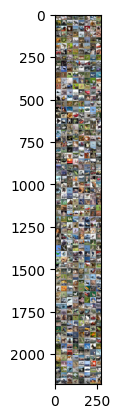

cat   dog   frog  truck ship  dog   ship  horse frog  dog   plane frog  plane cat   horse horse car   horse cat   plane car   dog   frog  horse truck deer  truck deer  ship  cat   cat   frog  frog  frog  cat   plane deer  plane bird  horse horse frog  cat   horse cat   plane frog  car   truck truck horse deer  horse truck bird  frog  deer  frog  horse frog  horse frog  ship  frog  deer  cat   car   bird  truck truck horse car   horse plane deer  horse plane ship  car   car   frog  frog  horse car   frog  bird  plane plane deer  deer  dog   horse frog  frog  dog   deer  bird  bird  car   bird  bird  horse truck dog   plane ship  plane ship  deer  car   ship  car   cat   truck plane car   ship  dog   horse bird  deer  bird  frog  frog  deer  ship  car   plane truck truck plane ship  horse car   plane horse truck deer  cat   car   plane cat   ship  cat   plane ship  cat   frog  car   truck deer  car   deer  cat   bird  ship  dog   deer  bird  dog   plane dog   car   dog   frog  frog  frog

In [4]:
# functions to show an image for fun


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Building network definition

In [5]:
#based on VGG
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model=Net()

Loading in the model

In [7]:
PATH = ('./SGD_net.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [8]:
# Setting all layers to not change their weights with GD backpropagation

for param in PopModel.parameters():
    # By setting the requires grad for each parameter to false, we no longer track it with autograd
    # Consequently, backpropagation or whatever will not compute the gradients for these layers
    param.requires_grad = False

Getting the final layer

In [9]:
finalLayer = PopModel.classifier[-1]

print(finalLayer) # 10 features out

outerShape = len(finalLayer.weight)
innerShape = len(finalLayer.weight[0])

totalWeights = outerShape * innerShape

print(outerShape) # 10 population size
print(innerShape) # 10 arrays, with 52 items in it

biasCount = len(finalLayer.bias)
print(biasCount)

paramCount = sum(param.numel() for param in finalLayer.parameters())

print(paramCount) # 530 Parameters: 520 weights + 10 biases


Linear(in_features=52, out_features=10, bias=True)
10
52
10
530


In [10]:
# Randomise final layer weights
nn.init.xavier_uniform(finalLayer.weight)
print((finalLayer.weight).shape) # Shape that the layer requires is (10,84)
print((finalLayer.bias).shape)

torch.Size([10, 52])
torch.Size([10])


<ipython-input-10-0638b396f9c2>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(finalLayer.weight)


In [ ]:
# Converting weights to a numpy array
def convert_np_function(self, intermediate_tensor):
        intermediate_value = intermediate_tensor.numpy()
        self.intermediate_values.append(intermediate_value)

populationList = finalLayer.weight.numpy()

Defining PSO functions

In [12]:
posMinInit      = -0.1
posMaxInit      = + 0.1
VMaxInit        = 1.5
VMinInit        = 0.5
# populationSize  = 3
dimension       = paramCount
populationSize  = 100+int(dimension/10) # from lab on SL-PSO
#interval        = 10
interval = 1
iterations      = 100

#variables used in SL-PSO
epsilon = dimension/100.0*0.01 # social influence of swarm centre

# Criterion for measuring loss, may need to tweak this to return negative value for PSO
criterion = nn.CrossEntropyLoss()

lossTracker = []

accuracyTracker = []

In [13]:
# function to get the mean positions of the inviduals (swarm centre)
def getcenter(pop):
    center=list()
    for j in range(dimension): # count through dimensions
        centerj = 0
        for i in pop: # for each particle
            centerj += i[j] # sum up position in dimention j
        centerj /= populationSize # Average
        center.append(centerj)
    return center

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)

In [20]:
# particle rerpresented by list of 5 things
# 1. fitness of the particle,
# 2. speed of the particle which is also going to be a list,
# 3.4. limit of the speed value,
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size))
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

def updateParticle(part,pop,center,i):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    r3 = random.uniform(0, 1)

    #Randomly choose a demonstrator for particle i from any of particles 0 to i-1, the Particle i
    #updates its velocity by learning from the demonstrator and the mean position of the swarm
    demonstrator=random.choice(list(pop[0:i]))

    for j in range(dimension): # count through dimensions
        part.speed[j]=r1*part.speed[j]+r2*(demonstrator[j]-part[j])+r3*epsilon*(center[j]-part[j])
        part[j]=part[j]+part.speed[j]

def getBestAccuracy(bestParticle):
    bestNP = np.array(bestParticle)

    # Splitting into weights and biases
    bestWeights = bestNP[:totalWeights]
    bestBiases = bestNP[-biasCount:]

    # Putting biases in
    bestBiases = torch.from_numpy(bestBiases).float()
    finalLayer.bias = torch.nn.Parameter(bestBiases.float())

    # Reshaping weights so they are correct for the layer
    bestWeights = bestWeights.reshape(outerShape,innerShape)

    # Converting to torch array
    bestWeights = torch.from_numpy(bestWeights).float()

    # Putting the weights into the layer
    finalLayer.weight = torch.nn.Parameter(bestWeights.float())

    correct_pred = 0
    total_pred = 0

    PopModel.to(device)

    for data in testloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = PopModel(images)

    _, predictions = torch.max(outputs, 1)

    # collect the correct predictions for each class

    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred += 1
      total_pred += 1

    acc = (correct_pred / total_pred)*100


    print("Accuracy of current best particle: " + str(acc) + "%")

    return acc

In [18]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)

# Note most likely need to change the evaluate function
toolbox.register("evaluate", benchmarks.sphere) #sphere function is built-in in DEAP

runCounter = 0

def modelEval(particle, runCounter):
    runCounter = runCounter
    runCounter +=1
    #print("hello!")

    # First step to get the particles weights out from it, convert to an numpy array
    particleweightsNP1 = np.array(particle)

    #particleweightsNP = particleweightsNP1[:840]
    #biases = np.array(particleweightsNP1[-10:])
    particleweightsNP = particleweightsNP1[:totalWeights]
    biases = np.array(particleweightsNP1[-biasCount:])

    # Putting biases straight in
    biases = torch.from_numpy(biases).float()
    finalLayer.bias = torch.nn.Parameter(biases.float())

    #print(particleweightsNP)

#     print("Shape of particle: " + str(particleweightsNP.shape))

    # Converting to the correct shape!
    reshapedWeights = particleweightsNP.reshape(outerShape,innerShape)
#     print("Shape of reshaped particle: " + str(reshapedWeights.shape))

    # Convert to torch array!
    torchWeights = torch.from_numpy(reshapedWeights).float()

    # Now we want to set the weights of the finalLayer to these weights

    finalLayer.weight = torch.nn.Parameter(torchWeights.float())

    # print("After:\n")
    # print(finalLayer.weight)

    #finalLayer.weight.data = torchWeights.float()
    #print(finalLayer.weight) # Note that the numbers look different than torchWeights ?
    #print(torchWeights)

    # Run a training loop for the model, with the particles weights set to the final layer and return a loss value back

    epoch_loss = 0.0
    running_loss = 0.0

    # reshapedWeights.to(device)
    # torchWeights.to(device)

#     print(f"Starting training run {runCounter}...")

    PopModel.to(device)

    for epoch in range(1):

        epoch_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # Getting the predictions for the model
            outputs = PopModel(inputs)

            loss = criterion(outputs, labels)

            #print(loss.item())

            epoch_loss += loss.item()

#         print("End of Epoch:" + str(epoch))

        running_loss += (epoch_loss / i)

    # Now we have a loss value:
    #print("Total Loss: " + str(running_loss))


    return running_loss, # This may be the wrong this to pass back, one test run showed loss is 835852, remember to check that it definitely doesnt update through gradient!

    # High loss could be due to how the weights were initialised or how they were converted between numpy and torch tensor?

    # We need to return one value

    #object of type 'NoneType' has no len() # Error when not returning anything.
    #object of type 'float' has no len() # Error when returning_loss by itself, investigate the output of the original sphere function?

    # Original loss function returns a single value. example output looks like (136.3042681576523,)

    # Do you need to return a list, with each epoch loss in there?
    # Doing this: Assigned values have not the same length than fitness weights
    # Update: Do not return a list

toolbox.register("evaluate2", modelEval)

In [21]:
def main():
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    #intialize the learning probabilities
    prob=[0]*populationSize
    for i  in range(len(pop)):
        prob[populationSize - i - 1] = 1 - i/(populationSize - 1)
        prob[populationSize - i - 1] = pow(prob[populationSize - i - 1], math.log(math.sqrt(math.ceil(dimension/100.0))))

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    # Mutation Tick, counts the number of times the swarm std deviation is below a certain amount
    MutationTick = 0

    #begin main loop
    for g in range(iterations):

        for part in pop:
            part.fitness.values = toolbox.evaluate2(part, runCounter) #actually only one fitness value

        #Sort the individuals in the swarm in ascending order. i.e., particle 0 is the best
        pop.sort(key=lambda x: x.fitness, reverse=True)
        #calculate the center (mean value) of the swarm
        center = getcenter(pop)

        # Code to update particle via velocity
        for i  in reversed(range(len(pop)-1)):  # start with worst particle, and go in reverse towards best
                                                # don't do element 0 (best). Hence the i+1 below.
            if random.uniform(0, 1)<prob[i+1]: #learning probability for that particle
                toolbox.update(pop[i+1],pop,center,i+1)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbookRecord = logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)

        avgloss = logbook.select("avg")[-1]

        # Add the average loss to the list, may not be necessary but it is useful
        lossTracker.append(avgloss)

        # Evaluate the accuracy of the current best particle

        accuracyTracker.append(getBestAccuracy(pop[0]))

    return pop, logbook

if __name__ == "__main__":
    superpart = main()

Total Loss: 43.373763133570094
Total Loss: 40.926744284089075
Total Loss: 47.24803877368416
gen	evals	avg    	std    	min    	max   
0  	3    	43.8495	2.60249	40.9267	47.248
Accuracy of current best particle: 12.5%
Current Mutation Tick: 0
Total Loss: 40.793819899411545
Total Loss: 43.07046375078024
Total Loss: 34.37735060072437
1  	3    	39.4139	3.68065	34.3774	43.0705
Accuracy of current best particle: 12.867647058823529%
Current Mutation Tick: 0
Total Loss: 34.532931160681024


KeyboardInterrupt: ignored

In [ ]:
# Quicksave the best particle

print(len(superpart[1])) # best particle has 840 weights in it
print(superpart[1])
arr = np.array(superpart[1])

print(arr.shape)

import csv

with open('superpart-030.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([superpart[0][0]])

with open('logbook-030.csv', 'a', newline='') as file:
    writer = csv.writer(file)
#     writer.writerows(["gen","evals","avg","std","min","max"])
    writer.writerows([superpart[1].select("gen"),superpart[1].select("evals"),superpart[1].select("avg"),
                      superpart[1].select("std"),superpart[1].select("min"),superpart[1].select("max")])